# Imports

In [2]:
import json
import random
from datetime import datetime, timedelta
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import textwrap
import numpy as np
from ortools.linear_solver import pywraplp

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Helper Functions Definitions

In [3]:

# Function to simulate random names for jobs
def generate_random_name():
    names = ["Inspection", "Repair", "Maintenance", "Installation", "Survey", "Configuration"]
    return random.choice(names)


In [11]:
def visualize_job_assignments(job_schedule, resources, date_range, jobs, title):
    """
    Visualize job assignments as calendar views for each resource.
    Shows dates on x-axis and time slots on y-axis with improved spacing.
    """
    start_date = datetime.strptime(date_range["start_date"], "%Y-%m-%d")
    end_date = datetime.strptime(date_range["end_date"], "%Y-%m-%d")
    dates = pd.date_range(start=start_date, end=end_date)
    time_slots = generate_time_slots("08:00", "17:00")
    
    # Calculate figure size based on content
    width = max(2 * len(dates), 15)      # At least 2 inches per date column
    height = 20 * len(resources)          # 20 inches per resource (significantly increased)
    
    # Create figure with much larger spacing between subplots
    fig, axes = plt.subplots(len(resources), 1, 
                            figsize=(width, height),
                            gridspec_kw={'hspace': 2.0,    # Double the spacing between subplots
                                       'top': 0.95,
                                       'bottom': 0.05,
                                       'left': 0.1,
                                       'right': 0.9})
    
    if len(resources) == 1:
        axes = [axes]
    
    # Create job lookup
    job_lookup = {job["id"]: job for job in jobs}
    
    for idx, resource in enumerate(resources):
        # Initialize empty table
        table_data = pd.DataFrame("", 
                                index=time_slots,
                                columns=dates.date)
        
        # Fill in assignments
        for event, assignment in job_schedule:
            if assignment["resource_id"] == resource["id"]:
                date = datetime.strptime(event["start_date"], "%Y-%m-%d").date()
                start_time = datetime.strptime(event["start_time"], "%H:%M")
                end_time = datetime.strptime(event["end_time"], "%H:%M")
                
                job = job_lookup[event["job_id"]]
                job_text = f"{job['id']}\n({', '.join(job['required_skills'])})"
                
                current_time = start_time
                while current_time < end_time:
                    time_slot = current_time.strftime("%H:%M")
                    if time_slot in table_data.index:
                        table_data.at[time_slot, date] = job_text
                    current_time += timedelta(minutes=30)
        
        ax = axes[idx]
        ax.axis('off')
        
        # Add resource title with skills above the table
        resource_title = f"Resource: {resource['id']}\nSkills: {', '.join(resource['skills'])}"
        ax.text(0.5, 1.1, resource_title, 
                horizontalalignment='center',
                fontsize=12,
                transform=ax.transAxes)
        
        # Create color mapping
        cell_colors = [['beige' if cell == "" else 'lightblue' 
                       for cell in row] 
                      for row in table_data.values]
        
        # Create table with adjusted properties
        table = ax.table(
            cellText=table_data.values,
            rowLabels=table_data.index,
            colLabels=[d.strftime("%Y-%m-%d") for d in table_data.columns],
            cellColours=cell_colors,
            loc='center',
            cellLoc='center'
        )
        
        # Adjust table formatting
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        
        # Calculate equal column width
        col_width = 1.0 / (len(table_data.columns) + 1)
        
        # Set uniform cell properties
        for (i, j), cell in table.get_celld().items():
            cell.set_height(0.08)  # Reduced cell height
            cell.set_width(col_width)
            
            if i == 0:  # Column headers
                cell.set_height(0.1)
                cell.set_text_props(wrap=True)
    
    # Add overall title
    fig.suptitle(title, fontsize=16, y=0.98)
    
    # No need for tight_layout as we're controlling spacing with gridspec
    plt.show()

In [12]:
import json

def export_job_schedule_to_json(job_schedule: List[Tuple[Dict, Dict]], filename: str):
    """
    Export the job schedule to a JSON file.
    
    Parameters:
    - job_schedule (List[Tuple[Dict, Dict]]): The list containing job events and assignments.
    - filename (str): The name of the output JSON file.
    """
    # Prepare data in a structured format
    export_data = []
    for event, assignment in job_schedule:
        export_data.append({
            "event": {
                "name": event["name"],
                "job_id": event["job_id"],
                "start_date": event["start_date"],
                "end_date": event["end_date"],
                "start_time": event.get("start_time"),
                "end_time": event.get("end_time"),
            },
            "event_assignment": {
                "id": assignment.get("id"),
                "event_id": assignment.get("event_id"),
                "resource_id": assignment["resource_id"],
                "key": assignment.get("key"),
            }
        })
    
    # Write to a JSON file
    with open(filename, "w") as json_file:
        json.dump(export_data, json_file, indent=4)
    
    print(f"Job schedule exported successfully to {filename}")

In [13]:
def generate_time_slots(start_time="08:00", end_time="17:00", interval_minutes=30):
    """
    Generate time slots between start_time and end_time at specified intervals.
    
    Parameters:
    - start_time (str): Start time in "HH:MM" format
    - end_time (str): End time in "HH:MM" format
    - interval_minutes (int): Time interval in minutes
    
    Returns:
    - list: List of time slots in "HH:MM" format
    """
    time_slots = []
    current = datetime.strptime(start_time, "%H:%M")
    end = datetime.strptime(end_time, "%H:%M")
    
    while current <= end:
        time_slots.append(current.strftime("%H:%M"))
        current += timedelta(minutes=interval_minutes)
    
    return time_slots

# Generate Input Data

In [14]:
def generate_test_data(num_jobs=30, num_resources=5, num_days=5):
    """
    Generate test data with estimated durations for jobs
    
    Parameters:
    - num_jobs: Number of jobs to generate
    - num_resources: Number of resources to generate
    - num_days: Number of days in the scheduling window
    
    Returns:
    - Dictionary containing the test data
    """
    from datetime import datetime 
    
    # Generate date range
    start_date = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
    date_range = {
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": (start_date + timedelta(days=num_days-1)).strftime("%Y-%m-%d")
    }
    
    # Define possible skills
    # all_skills = ["Electrical", "Mechanical", "Software", "Network", "HVAC", 
                #  "Plumbing", "Carpentry", "Welding", "Safety", "Quality"]
    
    # Generate resources
    resources = []
    for i in range(num_resources):
        # Each resource has 2-4 random skills
        # num_skills = random.randint(2, 4)
        # skills = random.sample(all_skills, num_skills)
        skills = []
        
        resources.append({
            "id": f"RES_{i+1:03d}",
            "name": f"Resource {i+1}",
            "skills": skills
        })
    
    # Generate jobs
    jobs = []
    job_ids = []
    for i in range(num_jobs):
        # Each job requires 1-3 random skills
        # num_required_skills = random.randint(1, 3)
        # required_skills = random.sample(all_skills, num_required_skills)
        required_skills = []
        
        # Generate random duration in 30-minute increments (0.5 to 8 hours)
        duration_hours = round(random.uniform(0.5, 8) * 2) / 2
        
        job_id = f"JOB_{i+1:03d}"
        jobs.append({
            "id": job_id,
            "name": generate_random_name(),
            "required_skills": required_skills,
            "priority": random.randint(1, 3),  # 1=high, 2=medium, 3=low
            "estimated_duration": duration_hours  # in hours
        })
        job_ids.append(job_id)
    
    # Compile all data
    test_data = {
        "date_range": date_range,
        "resources": resources,
        "jobs": jobs,
        "job_ids": job_ids
    }
    
    return test_data

# Generate and display sample test data
test_data = generate_test_data(num_jobs=20, num_resources=5, num_days=5)  # Smaller sample for easy viewing

print("\nDate Range:")
print(json.dumps(test_data["date_range"], indent=2))

print("\nSample Resources (first 2):")
print(json.dumps(test_data["resources"][:2], indent=2))

print("\nSample Jobs (all 5):")
print(json.dumps(test_data["jobs"], indent=2))


Date Range:
{
  "start_date": "2025-01-03",
  "end_date": "2025-01-07"
}

Sample Resources (first 2):
[
  {
    "id": "RES_001",
    "name": "Resource 1",
    "skills": []
  },
  {
    "id": "RES_002",
    "name": "Resource 2",
    "skills": []
  }
]

Sample Jobs (all 5):
[
  {
    "id": "JOB_001",
    "name": "Repair",
    "required_skills": [],
    "priority": 3,
    "estimated_duration": 1.5
  },
  {
    "id": "JOB_002",
    "name": "Inspection",
    "required_skills": [],
    "priority": 2,
    "estimated_duration": 3.5
  },
  {
    "id": "JOB_003",
    "name": "Installation",
    "required_skills": [],
    "priority": 3,
    "estimated_duration": 3.5
  },
  {
    "id": "JOB_004",
    "name": "Survey",
    "required_skills": [],
    "priority": 1,
    "estimated_duration": 2.5
  },
  {
    "id": "JOB_005",
    "name": "Inspection",
    "required_skills": [],
    "priority": 3,
    "estimated_duration": 5.5
  },
  {
    "id": "JOB_006",
    "name": "Maintenance",
    "required_skil

# OR-Tools 

In [15]:
def ortools_auto_schedule(data):
    """
    Schedule jobs with estimated durations using OR-Tools.
    Includes objective term to encourage even distribution among resources.
    """
    job_ids = data["job_ids"]
    resources = data["resources"]
    jobs = data["jobs"]
    start_date = datetime.strptime(data["date_range"]["start_date"], "%Y-%m-%d")
    end_date = datetime.strptime(data["date_range"]["end_date"], "%Y-%m-%d")
    
    dates = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d") 
             for i in range((end_date - start_date).days + 1)]
    time_slots = generate_time_slots("08:00", "17:00")
    
    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        print("Solver unavailable.")
        return []
    
    # Decision variables
    x = {}
    for job in jobs:
        for res in resources:
            for date in dates:
                for time_slot in time_slots:
                    x[job["id"], res["id"], date, time_slot] = solver.BoolVar(
                        f'x_{job["id"]}_{res["id"]}_{date}_{time_slot}')
    
    # Helper variables to track total work hours per resource
    resource_hours = {}
    for res in resources:
        resource_hours[res["id"]] = solver.NumVar(0, solver.infinity(), f'hours_{res["id"]}')
        
        # Calculate total hours assigned to this resource
        solver.Add(resource_hours[res["id"]] == 
                  solver.Sum(x[job["id"], res["id"], date, time_slot] * (1/2)  # 1/2 hour per time slot
                           for job in jobs 
                           for date in dates 
                           for time_slot in time_slots))
    
    # Calculate average hours per resource
    avg_hours = solver.NumVar(0, solver.infinity(), 'avg_hours')
    solver.Add(avg_hours == solver.Sum(resource_hours[res["id"]] for res in resources) / len(resources))
    
    # Variables to track deviation from average
    max_deviation = solver.NumVar(0, solver.infinity(), 'max_deviation')
    for res in resources:
        # Ensure max_deviation is greater than both positive and negative differences from average
        solver.Add(max_deviation >= resource_hours[res["id"]] - avg_hours)
        solver.Add(max_deviation >= avg_hours - resource_hours[res["id"]])
    
    # Original objective components
    total_assignments = solver.Sum(x[job["id"], res["id"], date, time_slot] 
                                 for job in jobs 
                                 for res in resources 
                                 for date in dates 
                                 for time_slot in time_slots)
    
    # Combined objective: maximize assignments while minimizing deviation
    # The coefficient 0.1 determines how much we care about even distribution vs total assignments
    solver.Maximize(total_assignments - 0.1 * max_deviation)
    
    # Add existing constraints...
    # Constraint 1: Each job must be scheduled exactly once
    for job in jobs:
        solver.Add(solver.Sum(x[job["id"], res["id"], date, time_slot] 
                            for res in resources 
                            for date in dates 
                            for time_slot in time_slots) == 1)
    
    # Constraint 2: Each resource can only handle one job at a time
    for res in resources:
        for date in dates:
            for time_slot_idx in range(len(time_slots)):
                active_jobs = solver.Sum(
                    x[job["id"], res["id"], date, time_slots[max(0, time_slot_idx - int(job["estimated_duration"] * 2) + 1)]] 
                    for job in jobs
                    if time_slot_idx < len(time_slots)
                )
                solver.Add(active_jobs <= 1)
    
    # Constraint 3: Skill matching
    for job in jobs:
        required_skills = set(job["required_skills"])
        for res in resources:
            if not required_skills.issubset(set(res["skills"])):
                for date in dates:
                    for time_slot in time_slots:
                        solver.Add(x[job["id"], res["id"], date, time_slot] == 0)
    
    # Solve and extract solution as before...
    status = solver.Solve()
    
    # Extract the solution
    job_schedule = []
    if status == pywraplp.Solver.OPTIMAL:
        print(f"Optimal solution found with {int(solver.Objective().Value())} objective value")
        print("\nResource workload distribution:")
        for res in resources:
            hours = resource_hours[res["id"]].solution_value()
            print(f"{res['id']}: {hours:.1f} hours")
        print(f"Average hours per resource: {avg_hours.solution_value():.1f}")
        print(f"Maximum deviation from average: {max_deviation.solution_value():.1f} hours")
        
        for job in jobs:
            for res in resources:
                for date in dates:
                    for time_slot_idx, start_time in enumerate(time_slots):
                        if x[job["id"], res["id"], date, start_time].solution_value() == 1:
                            start_dt = datetime.strptime(start_time, "%H:%M")
                            duration_minutes = int(job["estimated_duration"] * 60)
                            end_dt = start_dt + timedelta(minutes=duration_minutes)
                            end_time = end_dt.strftime("%H:%M")
                            
                            event = {
                                "name": f"Job {job['id']}",
                                "job_id": job["id"],
                                "start_date": date,
                                "end_date": date,
                                "start_time": start_time,
                                "end_time": end_time
                            }
                            event_assignment = {
                                "id": None,
                                "event_id": None,
                                "resource_id": res["id"],
                                "key": None
                            }
                            job_schedule.append((event, event_assignment))
    else:
        print("No optimal solution found.")

    return job_schedule

Optimal solution found with 20 objective value

Resource workload distribution:
RES_001: 2.0 hours
RES_002: 2.0 hours
RES_003: 2.0 hours
RES_004: 2.0 hours
RES_005: 2.0 hours
Average hours per resource: 2.0
Maximum deviation from average: 0.0 hours


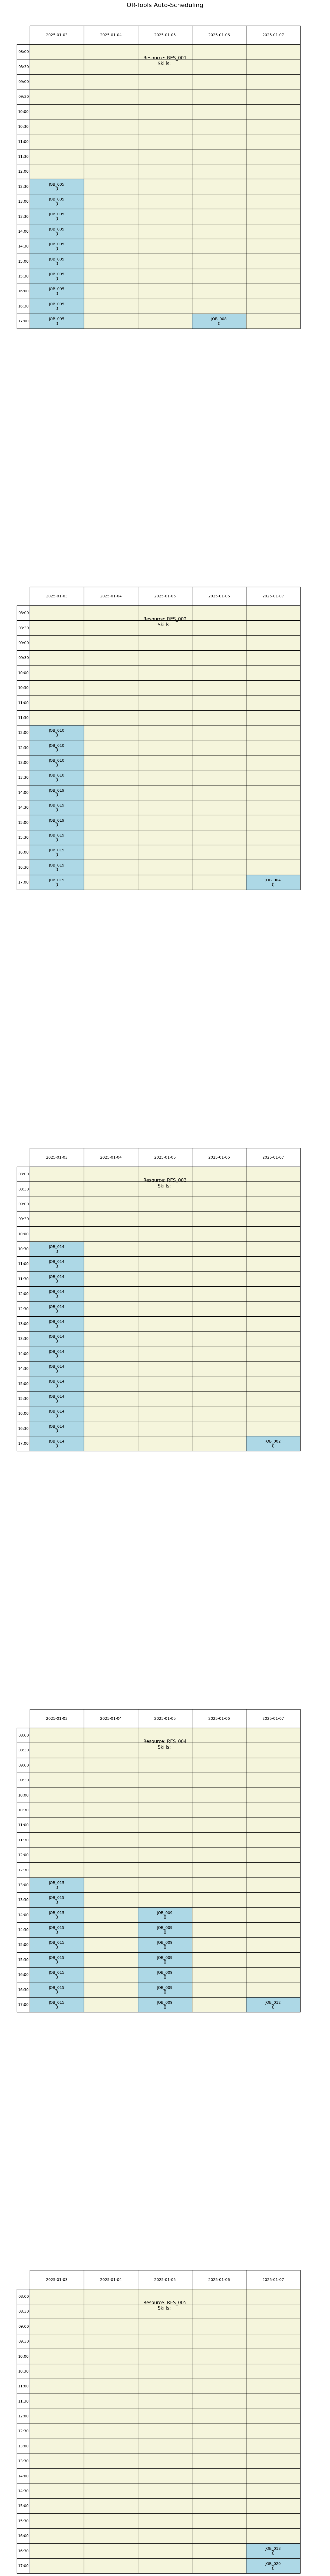

In [16]:
job_schedule = ortools_auto_schedule(test_data)

visualize_job_assignments(
    job_schedule, 
    test_data["resources"], 
    test_data["date_range"], 
    test_data["jobs"], 
    "OR-Tools Auto-Scheduling"
)